### Machine Learning Education Projects:

* ## Image Captioning Problem

* ## Text Generation Problem
 
### *Disclaimer:*
* #### *Hardware:*
* ###### CPU: Intel Core i5-7300HQ
* ###### RAM: 16 GB
* ###### GPU: Nvidia GTX 1050 | 2GB
* #### *Keras Backend: Tensorflow 2.3 GPU*

## Image Captioning

### Model based on [Image Captioning with Keras](https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8)
### Data was acquiered from [Common Objects in Context website](https://cocodataset.org/#download)
### datasets:
#### Number of Training Images: 82783
#### Number of Validation Images: 40504


### Given that the datasets are relatively massive, two strategies are followed:
- #### Serialize data, which was taken care of in the Data Exploration kernel
- #### Use generator functions in the Training/Validation process to save memory usage. (Explained on training section)

### Load the serialized preprocessed images

```python
# Load serialized preprocessed images

train_features = load(open("data/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))
# %store train_features

test_features = load(open("data/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))
# %store test_features

```

### From the Data Exploration Kernel, we take the files created for the captions and add *SOS* and *EOS* labels.

#### SOS: Start of Sentence
#### EOS: End of Sentence

### As aforementioned on the Data Exploration Kernel, to exclude outlier words, those which incidence is solely once, will be removed. 

```python
# Read Data and Add Start and End Labels
data = 'data/' 
files = [''.join([data, file]) for file in os.listdir(data) if 'captions' in file]
# files = ['data/tr_captions.txt', 'data/v_captions.txt']
tr_caps, v_caps = dict(), dict()
for caps, file in zip([tr_caps, v_caps], files):
    with open(file, 'r') as f:
        captions = f.read().split('\n')
        
    captions = [[cap.split()[0], ' '.join(cap.split()[1:])] for cap in captions]
    
    for id_, cap in tqdm(captions):
        if id_ not in caps.keys():
            caps[id_] = list()
        cap = ' '.join(['SOS', cap, 'EOS'])
        caps[id_].append(cap)

# Join Train and Validation captions
all_caps, all_features = {**tr_caps, **v_caps}, {**train_features, **test_features}

# Filter corpus on words that appear more than once
voc = ''
for k, caps in all_caps.items():
    voc += ' ' + ' '.join(caps) + ' '
voc = Counter(voc.split()).most_common()

new_voc = list(filter(lambda x : x[1]>1, voc))

print(len(new_voc), len(all_caps), len(all_features))
```

### Tokenization

#### We've been working with two dataset so far: Training and Validation; however, i'm going to join both's vocabularies to embed them at once. 

#### The common ix2word/word2ix convention will be harnessed. 

#### ```max_length = 50``` is concluded form the Data Exploration Kernel

```python
ixtoword = {}
wordtoix = {}

ix = 1
for w, _ in new_voc:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1 # one for appended 0's
print(f'Ix to word: done\n with {vocab_size} words')

max_length = 50
```


#### Gobal Vectors (GloVe) Embedding will be used, through the [glove.6B.200d](https://www.kaggle.com/incorpes/glove6b200d) database. It has 6 billion words embedded in 200-D vectors. It was developed by the GloVe method creators Jeffrey Pennington, Richard Socher, and Christopher D. Manning. [Source](https://nlp.stanford.edu/projects/glove/)

#### The next cell will create a script to download the Embeddings files. There are other embeddeing sizes, so you can play with those too. 

#### Once you already have the GloVe vectors, create a dictonary assigning the correspondent vector to each word. 

```python
embeddings_index = {} # empty dictionary
f = open(os.path.join(data, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print(f'Found {len(embeddings_index)} word vectors.')
```
#### In this dicionary, get the vectors for the words our vocabulary does have
```python
embedding_dim = 200

# Get 200-dim dense vector for each word in our vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tqdm(wordtoix.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape
```

In [1]:
%%writefile scripts/download_glove.py

import wget
import os
import zipfile
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


def downloadAndUnzip(url, zipFile, folder):
    print(f'working on {zipFile}')
    if not os.path.isfile(zipFile):
        wget.download(url, zipFile) # download .zip file from url source
    if not os.path.isdir(zipFile.replace('.zip','')):
        with zipfile.ZipFile(zipFile, 'r') as zip_: # unzip in a given folder
            for member in tqdm(zip_.infolist(), desc='Extracting'):
                try:
                    zip_.extract(member, folder)
                except zipfile.error as e:
                    pass
    print(f'zip file {zipFile} has been downloaded and extracted in {folder}')

if __name__ == '__main__':
    # create data folder if inexistent
    folder = 'data/'
    if not os.path.isdir(folder):
        os.makedirs(folder)
        
    url = 'https://nlp.stanford.edu/data/glove.6B.zip'
    zipFile = 'data/glove.6B.zip'
    
    downloadAndUnzip(url, zipFile, folder)
        

Writing scripts/download_glove.py


In [ ]:
# run in terminal
# !python scripts/download_glove.py

### Keras Model Architecture

#### For the images analysis, a transfered learning strategy takes place invoking Google's Inception V.3 model. This model is for classification, which is not what we're intended to do; therefore, the last layer is dropped (where the classification happens) and we continue from the last layer's output vector of 2048-D. 

#### Concurrently a text generator model will be running taking in the current text sequence, bidding the embedding transformations and outputing a 24,742-D vector (vocabulary length)

#### The following image explains the overall model.

<img src="model_arch.jpeg" width="700" height="700"/>

#### The second part of the model construction follows the next code. 

```python
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

model.layers[2]
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')
```

### Generator Function

#### Too much memory?, lets see: 
#### We have more than 120,000 images with 5 captions, on average, with 10 words each, on average. That gives 6,000,000 data points in an initial stage. 
#### the data matrix size is $ n*m $, where *n* is our estimate number of data points and *m* is the length of each data point. *m* incluedes the 2048-D vector, but it also incluedes de 200-D word embedding through sequences with a max. length of 50 words. *i.e*, $ m = 2048 + (200 * 50) = 12048 $.
#### data matrix size $= 6,000,000 * 12,048 = 72,288,000,000$Blocks
#### Let's say that each block takes 2 bytes, this will require 33.66 GB of memory, which I don't have. 

#### So, with a generator, instead of bringing all into memory and then processing it, we can generate batches of data mantaining the learning flow and a low memory usage. 
```python
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            try:
                photo = photos['COCO_train2014_'+key+'.jpg']
            except:
                photo = photos['COCO_val2014_'+key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0
```

#### After several trials, I was unsatisfied with the results, so I merged the training and validation data and splitted them manually. I chose a valildation set proportion of 30%.

#### There is too much data, so there is no need to run many EPOCHs, otherwise, the model might be highly prone to overfitting. I chose 10 EPOCHs and after the 5th EPOCH, the Learning rate decreases from 0.001 to 0.0001. 

#### Just for tunning the model a bit more, afterwards, another 10 EPOCHs were run, but trained only on the validation set at learning rate of 0.0001 to prevent overfitting. 

#### this process took more than 6 hours. To spare this time, the models are already saved and ready to simply be loaded. However, here's the script and a screenshot of the learning process as evidence and for code review.
```python
# Validation proportion 0.3 = 30%
    val_prop = 0.3
    caps_tr, caps_v = dict(), dict()
# Randomnized shuffle
    for k, cap in caps.items():
        if random.random() <= val_prop: caps_v[k] = cap
        else: caps_tr[k] = cap

    print(f'training data: {len(caps_tr)} \nvalidation data: {len(caps_v)}')

    epochs = 10
    number_pics_per_bath = 10
    steps_tr = len(caps_tr)//number_pics_per_bath
    steps_v = len(caps_v)//number_pics_per_bath

    for i in range(epochs):

        gen = data_generator(caps_tr, features, wordtoix, max_length, number_pics_per_bath)

        if i > 5:
            def scheduler(_):
                return 0.0001
            callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
        else:
            def scheduler(_):
                return 0.001
            callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Fit
        model.fit_generator(gen,
                        epochs=1,
                        steps_per_epoch=steps_tr, verbose=1,
                        callbacks = [callback],
                        validation_data=gen_v,
                        validation_steps=steps_v)

        model.save(''.join([model, 'model_tr75val25_', str(i),'.h5']))
                   
    
    epochs = 5
    number_pics_per_bath = 5
    steps_v = len(caps_v)//number_pics_per_bath

    for i in range(epochs):

        gen_v = data_generator(caps_v, features, wordtoix, max_length, number_pics_per_bath)

        def scheduler(_):
            return 0.0001
        callback = tf.keras.callbacks.LearningRateScheduler(scheduler)        

        model.fit_generator(gen_v,
                        epochs=1,
                        steps_per_epoch=steps_v, verbose=1,
                        callbacks = [callback])

        model.save(''.join([model, 'model_tr75val25_', 10 + str(i),'.h5']))
    

```

In [16]:
%%writefile scripts/machine_learning_model_and_training.py
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
physical_devices = tf.config.list_physical_devices('GPU') 
tf.test.is_built_with_cuda()
print(f'Using GPU: {tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)}')

import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import string
import os
from PIL import Image
import glob
from pickle import dump, load
import random
from time import time
from collections import Counter
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                                    Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import add
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras


def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            try:
                photo = photos['COCO_train2014_'+key+'.jpg']
            except:
                photo = photos['COCO_val2014_'+key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

                
if __name__ == '__main__':  
    
    # Load serialized preprocessed images

    train_features = load(open("data/encoded_train_images.pkl", "rb"))
    print('Photos: train=%d' % len(train_features))

    test_features = load(open("data/encoded_test_images.pkl", "rb"))
    print('Photos: test=%d' % len(test_features))
    
# Read Data and Add Start and End Labels
    data = 'data/' 
    files = [''.join([data, file]) for file in os.listdir(data) if 'captions' in file]
    # files = ['data/tr_captions.txt', 'data/v_captions.txt']
    tr_caps, v_caps = dict(), dict()
    for caps, file in zip([tr_caps, v_caps], files):
        with open(file, 'r') as f:
            captions = f.read().split('\n')

        captions = [[cap.split()[0], ' '.join(cap.split()[1:])] for cap in captions]

        for id_, cap in tqdm(captions):
            if id_ not in caps.keys():
                caps[id_] = list()
            cap = ' '.join(['SOS', cap, 'EOS'])
            caps[id_].append(cap)

    # Join Train and Validation captions
    all_caps, all_features = {**tr_caps, **v_caps}, {**train_features, **test_features}

    # Filter corpus on words that appear more than once
    voc = ''
    for k, caps in all_caps.items():
        voc += ' ' + ' '.join(caps) + ' '
    voc = Counter(voc.split()).most_common()

    new_voc = list(filter(lambda x : x[1]>1, voc))

    print(len(new_voc), len(all_caps), len(all_features))
    ixtoword = {}
    wordtoix = {}

    ix = 1
    for w, _ in new_voc:
        wordtoix[w] = ix
        ixtoword[ix] = w
        ix += 1

    vocab_size = len(ixtoword) + 1 # one for appended 0's
    print(f'Ix to word: done\n with {vocab_size} words')

    max_length = 50
    
    embeddings_index = {} # empty dictionary
    f = open(os.path.join(data, 'glove.6B.300d.txt'), encoding="utf-8") # changed from 200d

    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print(f'Found {len(embeddings_index)} word vectors.')
    
    embedding_dim = 300 # changed from 200

    # Get 200-dim dense vector for each word in our vocabulary
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in tqdm(wordtoix.items()):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in the embedding index will be all zeros
            embedding_matrix[i] = embedding_vector
    embedding_matrix.shape
    
# Model
# directory where models will be stored
    data = 'data/'
    models = ''.join([data, 'models/'])
    if not os.path.isdir(models):
        os.makedirs(models)
    elif os.listdir(models):
        models_list = glob.glob(models+'/*')
        model_path = max(models_list, key=os.path.getctime)
        model = tf.keras.models.load_model(model_path)
    else:
        inputs1 = Input(shape=(2048,))
        fe1 = Dropout(0.5)(inputs1)
        fe2 = Dense(256, activation='relu')(fe1)
        inputs2 = Input(shape=(max_length,))
        se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
        se2 = Dropout(0.5)(se1)
        se3 = LSTM(256)(se2)
        decoder1 = add([fe2, se3])
        decoder2 = Dense(256, activation='relu')(decoder1)
        outputs = Dense(vocab_size, activation='softmax')(decoder2)
        model = Model(inputs=[inputs1, inputs2], outputs=outputs)


        model.layers[2]
        model.layers[2].set_weights([embedding_matrix])
        model.layers[2].trainable = False
        model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['mean_absolute_error'],
        )
    

# Validation proportion 0.3 => 30%
    val_prop = 0.3
    caps_tr, caps_v = dict(), dict()
# Randomnized shuffle
    for k, cap in all_caps.items():
        if random.random() <= val_prop: caps_v[k] = cap
        else: caps_tr[k] = cap

    print(f'training data: {len(caps_tr)} \nvalidation data: {len(caps_v)}')
    
    
    trained_model_file = ''.join([models, 'model_tr75val25_9.h5'])
    if not os.path.isfile(trained_model_file):
                                  
        epochs = 30
        number_pics_per_bath = 10
        steps_tr = len(caps_tr)//number_pics_per_bath
        steps_v = len(caps_v)//number_pics_per_bath

        for i in range(epochs):

            gen = data_generator(caps_tr, all_features, wordtoix, max_length, number_pics_per_bath)
            gen_v = data_generator(caps_v, all_features, wordtoix, max_length, number_pics_per_bath)

            if i > 5:
                def scheduler(_):
                    return 0.0001
                callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
            else:
                def scheduler(_):
                    return 0.001
                callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

    # Fit
            model.fit_generator(gen,
                            epochs=1,
                            steps_per_epoch=steps_tr, verbose=1,
                            callbacks = [callback],
                            validation_data=gen_v,
                            validation_steps=steps_v)

            model.save(''.join([models, f'model_tr{1-val_prop}val{val_prop}_', str(i),'.h5']))

    print("******* Training Dataset has been fed *******")
    validation_model_file = ''.join([models, 'model_tr75val25_14.h5'])
    if not os.path.isfile(validation_model_file):
                                  
        epochs = 5
        number_pics_per_bath = 5
        steps_v = len(caps_v)//number_pics_per_bath

        for i in range(epochs):

            gen_v = data_generator(caps_v, all_features, wordtoix, max_length, number_pics_per_bath)

            def scheduler(_):
                return 0.0001
            callback = tf.keras.callbacks.LearningRateScheduler(scheduler)        

            model.fit_generator(gen_v,
                            epochs=1,
                            steps_per_epoch=steps_v, verbose=1,
                            callbacks = [callback])

            model.save(''.join([models, f'model_tr{1-val_prop}val{val_prop}_val',  str(i),'.h5']))
    
    print("***** Validation Dataset has been fed *******")
    
    pick_obj = [wordtoix, max_length, ixtoword]
    pick_file = 'data/embedded_pickle'
    
    with open(pick_file, 'wb') as pf:
        dump(pick_obj, pf)

Overwriting scripts/machine_learning_model_and_training.py


In [25]:
# run in terminal
# !python scripts/machine_learning_model_and_training.py

In [17]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from collections import Counter
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                                    Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import add
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm_notebook as tqdm


import warnings
warnings.filterwarnings('ignore')

In [18]:
from pickle import load
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
physical_devices = tf.config.list_physical_devices('GPU') 
tf.test.is_built_with_cuda()
print(f'Using GPU: {tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)}')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Using GPU: True


In [19]:
final_features = load(open("test_images/encoded_final_images.pkl", "rb"))
print('Photos: final=%d' % len(final_features))
# %store test_features


pick_file = 'data/embedded_pickle'
with open(pick_file,'rb') as pf:
    pick_obj = load(pf)

wordtoix, max_length, ixtoword = pick_obj

data = 'data/'
models = ''.join([data, 'models/'])

models_list = glob.glob(models+'/*')
model_path = max(models_list, key=os.path.getctime)
model = tf.keras.models.load_model(model_path)
model.summary()

Photos: final=20


FileNotFoundError: [Errno 2] No such file or directory: 'data/embedded_pickle'

In [8]:
def greedySearch(photo):
    in_text = 'SOS'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'EOS':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

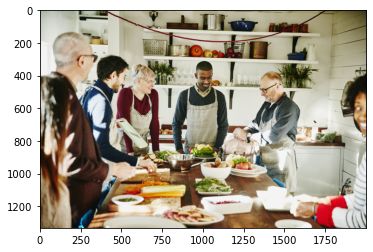

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Greedy: test_images/test_01.jpeg 
	  a group of people sitting around a table


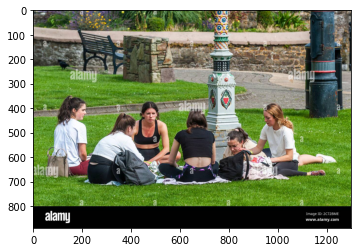

Greedy: test_images/test_02.jpeg 
	  a man holding a pair of scissors in a field


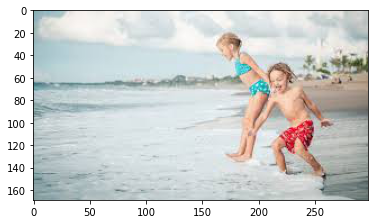

Greedy: test_images/test_03.jpeg 
	  a woman is holding a kite in the water


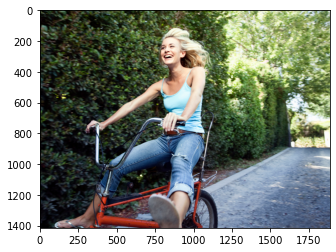

Greedy: test_images/test_04.jpeg 
	  a man is sitting on a bench with a pair of scissors


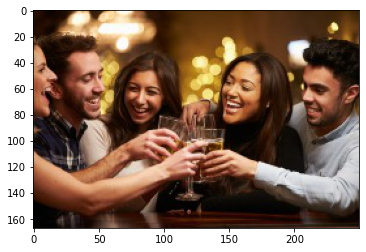

Greedy: test_images/test_05.jpeg 
	  a man sitting at a table with a glass of wine


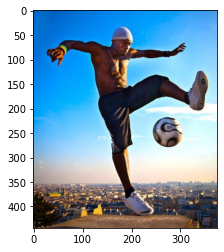

Greedy: test_images/test_06.jpeg 
	  a man is flying a kite in the air


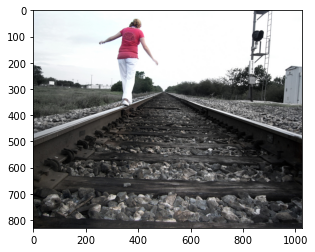

Greedy: test_images/test_07.jpeg 
	  a man standing on a bench with a pair of scissors


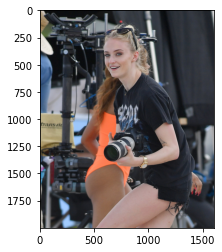

Greedy: test_images/test_08.jpeg 
	  a man holding a pair of scissors in a room


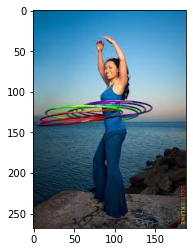

Greedy: test_images/test_09.jpeg 
	  a man is holding a kite in the water


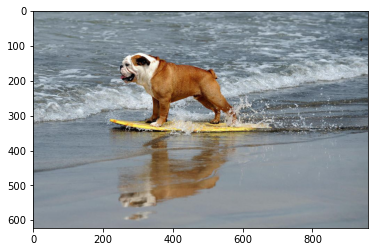

Greedy: test_images/test_10.jpeg 
	  a dog is sitting on a couch with a dog


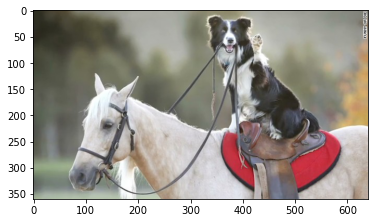

Greedy: test_images/test_11.jpeg 
	  a man is standing next to a horse


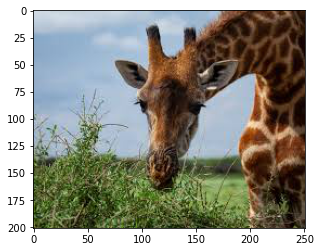

Greedy: test_images/test_12.jpeg 
	  a giraffe standing in a field with a pair of people


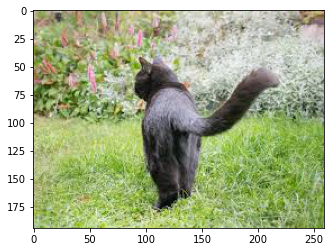

Greedy: test_images/test_13.jpeg 
	  a man holding a pair of scissors in a field


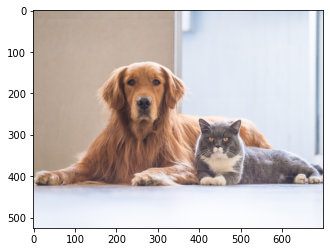

Greedy: test_images/test_14.jpeg 
	  a dog is sitting on a table with a pair of scissors


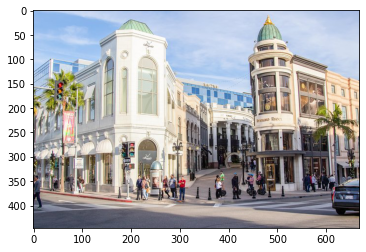

Greedy: test_images/test_15.jpeg 
	  a large building with a clock on it


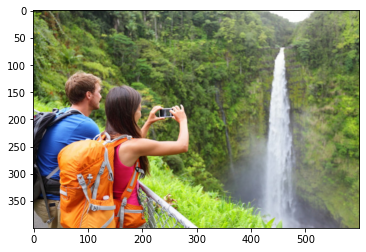

Greedy: test_images/test_16.jpeg 
	  a man is holding a pair of scissors


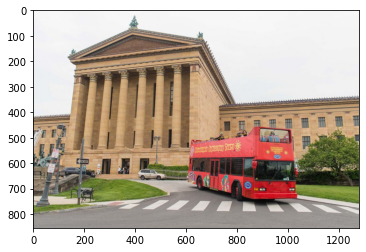

Greedy: test_images/test_17.jpeg 
	  a large building with a clock on it


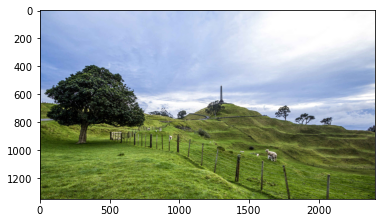

Greedy: test_images/test_18.jpeg 
	  a large white and white photo of a person on a field


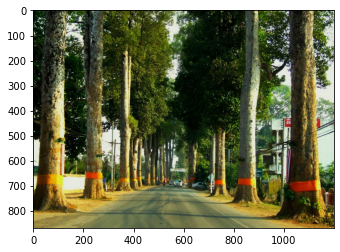

Greedy: test_images/test_19.jpeg 
	  a man is standing in a street with a pair of scissors


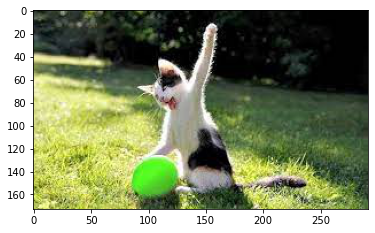

Greedy: test_images/test_20.jpeg 
	  a man holding a pair of scissors in a field


In [9]:
import random
folder = 'test_images/'
files = [''.join([folder, file]) for file in os.listdir(folder) if '.jpeg' in file]
for file in files:
#     z = random.choice(range(len(final_features)))
#     pic = list(final_features.keys())[z]
    image = final_features[file.replace(folder,'')].reshape((1,2048))
    x=plt.imread(file)
    plt.imshow(x)
    plt.show()
    print("Greedy: {} \n\t ".format(file),greedySearch(image))

In [6]:
import random
for _ in range(10):
    z = random.choice(range(len(test_features)))
    pic = list(test_features.keys())[z]
    image = test_features[pic].reshape((1,2048))
    x=plt.imread('data/val2014/'+pic)
    plt.imshow(x)
    plt.show()
    print("Greedy: {} \n\t ".format(pic),greedySearch(image))

NameError: name 'test_features' is not defined